In [2]:
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [3]:
# 데이터 분리
train_data = MNIST(root='./data', train=True, download=True, transform=ToTensor())
test_data = MNIST(root='./data', train=False, download=True, transform=ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 94075039.81it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 35923989.86it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 56676020.46it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3311983.44it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [12]:
len(train_data), len(test_data)

(60000, 10000)

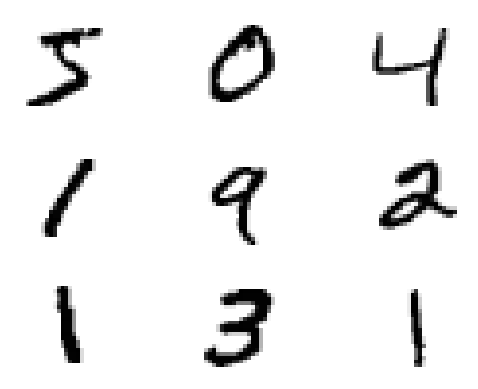

In [9]:
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(train_data.data[i],cmap='gray_r')
  plt.axis('off')
plt.show()

학습데이터와 평가데이터의 데이터로드 정의

In [24]:
from torch.utils.data.dataloader import DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [23]:
first_data = next(iter(train_loader))
# 데이터와, 정답
first_data[0].shape, first_data[1].shape

torch.Size([32, 1, 28, 28])

In [25]:
for data,target in train_loader:
  print(data, target)
  break


1875

모델 학습

In [27]:
import torch
import torch.nn as nn
from torch.optim.adam import Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [29]:
# 모델만들기
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64,10)
).to(device)  # 모델의 파라메터를 device로 보냄

lr = 1e-3
optim = Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss() # 분류모델에 사용

for epoch in range(20):
  for data, target in train_loader:
    data, target = data.to(device), target.to(device)
    # 예측
    preds = model(data)  # 예측
    # 손실함수
    loss = loss_fn(preds, target)
    loss.backward()
    optim.step()
    optim.zero_grad()
  print(f'epoch: {epoch+1}, loss: {loss.item()}')

epoch: 1, loss: 0.24656841158866882
epoch: 2, loss: 0.026895124465227127
epoch: 3, loss: 0.2363821268081665
epoch: 4, loss: 0.011053193360567093
epoch: 5, loss: 0.020385198295116425
epoch: 6, loss: 0.003477976191788912
epoch: 7, loss: 0.04955762252211571
epoch: 8, loss: 0.0037665939889848232
epoch: 9, loss: 0.0014378507621586323
epoch: 10, loss: 0.001987736439332366
epoch: 11, loss: 0.00019350004731677473
epoch: 12, loss: 5.215200872044079e-05
epoch: 13, loss: 0.0052414205856621265
epoch: 14, loss: 0.002456887159496546
epoch: 15, loss: 0.06589900702238083
epoch: 16, loss: 0.008975119329988956
epoch: 17, loss: 0.01055232435464859
epoch: 18, loss: 0.0007119989604689181
epoch: 19, loss: 0.14770953357219696
epoch: 20, loss: 0.0007430081022903323


모델 저장

In [30]:
torch.save(model.state_dict(), 'model.pth')  # 모델의 가중치만을 저장  불러오려면... 가중치를 저장했던 모델의 구조를 그대로 만들어서 불러와야 한다.

저장한 모델 불러오기

In [32]:
# 모델만들기
model2 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64,10)
).to(device)  # 모델의 파라메터를 device로 보냄

model2.load_state_dict(torch.load('model.pth'))

<ipython-input-32-1cad345f177e>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load('model.pth'))


<All keys matched successfully>

평가

In [41]:
num_correct = 0  # 맞춘개수
with torch.no_grad():
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    # 예측
    preds = model2(data)  # 예측
    # print(f'예측한 클래스 : {preds.argmax(dim=1)}')
    # print(f'target : {target}')
    # 올바르게 분류한 개수
    # print(output.eq(target).sum())
    # break
    output = preds.argmax(dim=1)
    num_correct += output.eq(target).sum()

print(f'정확도 : {num_correct/len(test_data)}')


정확도 : 0.9745000004768372


컬러이미지

In [42]:
from torchvision.datasets import CIFAR10

In [44]:
train_data = CIFAR10(root='./data2', train=True, download=True, transform=ToTensor())
test_data = CIFAR10(root='./data2', train=False, download=True, transform=ToTensor())

100%|██████████| 170498071/170498071 [00:02<00:00, 62389413.04it/s]


Extracting ./data2/cifar-10-python.tar.gz to ./data2
Files already downloaded and verified


In [52]:
for data, target in train_data:
  print(data.shape,target)
  break

torch.Size([3, 32, 32]) 6


In [53]:
# 데이터 로더
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [54]:
for data, target in train_loader:
  print(data.shape, target)
  break

torch.Size([32, 3, 32, 32]) tensor([2, 4, 8, 6, 3, 5, 7, 2, 7, 4, 1, 9, 3, 4, 2, 5, 4, 3, 4, 6, 8, 8, 6, 2,
        7, 2, 8, 0, 3, 6, 2, 4])


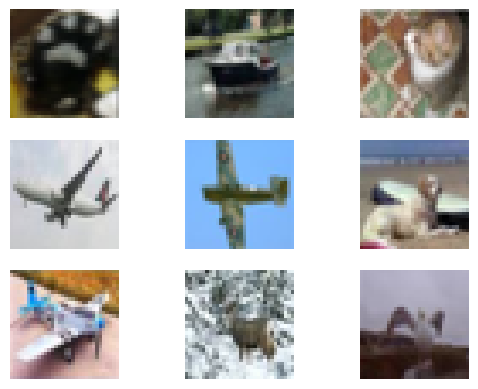

In [65]:
# 로더에서 배치사이즈 마큼 데이터 한번 가져오면
imsi = next(iter(train_loader))[0]
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(imsi[i].permute(1,2,0))  # 그림을 그리기 위해서는 rgb의 정보가 마지막 (채널,가로,세로) ->(가로,세로,채널)
  plt.axis('off')
plt.show()

데이터를 증폭
  - 프롭핑과 뒤집기를 추가

In [67]:
import torchvision.transforms as T
from torchvision.transforms import RandomCrop, RandomHorizontalFlip, Compose

In [74]:
transforms = Compose([
    T.ToPILImage(),
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(p=0.5), # 축을 기준으로 회전
    ToTensor()
])

In [75]:
# 데이터 가져오기
train_data = CIFAR10(root='./data2', train=True, download=True, transform=transforms)
test_data = CIFAR10(root='./data2', train=False, download=True, transform=transforms)

Files already downloaded and verified
Files already downloaded and verified


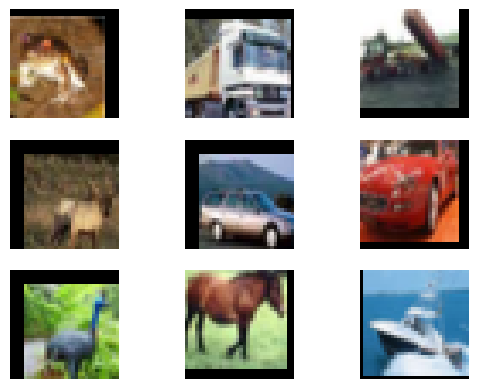

In [76]:
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(transforms(train_data.data[i]).permute(1,2,0) )
  plt.axis('off')
plt.show()

데이터 전처리에 정규화 추가

In [77]:
from torchvision.transforms import Normalize
transforms = Compose([
    T.ToPILImage(),
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(p=0.5), # 축을 기준으로 회전
    ToTensor(),
    # 데이터 정규화
    Normalize(mean = (0.4,0.4,0.4), std=(0.2,0.2,0.2)),
    T.ToPILImage(),
])

In [79]:
train_data.data.shape

(50000, 32, 32, 3)